In [637]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import matplotlib
import scipy

matplotlib.rcParams['figure.figsize'] = [10, 5]

In [638]:
with open("../export/image_catalogue.json") as ic_file:
    image_catalog = json.load(ic_file)
    types_map = [v["type"] for k, v in sorted(image_catalog.items()) if k.isnumeric()]

In [639]:
rating_files = glob.glob("../export/*_rating.csv")
rating_files.sort()
rating_files[-1]

'../export/20221221-075453_rating.csv'

In [640]:
questions = ["Fictional/Real", "Human-made/Human-like", "Eerie/Ordinary", "Unsettling/Plain", "Creepy/Dull",
             "Hair-raising/Unemotional", "Hostile/Friendly", "Grumpy/Cheerful", "Cold-hearted/Warm-hearted"]

In [641]:
ratings = pd.read_csv(rating_files[-1], index_col=["index"],
                      names=["index", "timestamp", "img"] + questions + ["uid"])
ratings = ratings.reset_index().drop(["index"], axis=1)
ratings["type"] = [types_map[img - 1] for img in ratings["img"]]

ratings["Fictional/Real"] -= 4
ratings["Human-made/Human-like"] -= 4
ratings["Eerie/Ordinary"] = 7 - ratings["Eerie/Ordinary"]
ratings["Unsettling/Plain"] = 7 - ratings["Unsettling/Plain"]
ratings["Creepy/Dull"] = 7 - ratings["Creepy/Dull"]
ratings["Hair-raising/Unemotional"] = 7 - ratings["Hair-raising/Unemotional"]
ratings["Hostile/Friendly"] -= 4
ratings["Grumpy/Cheerful"] -= 4
ratings["Cold-hearted/Warm-hearted"] -= 4

# Image Distribution

<AxesSubplot: >

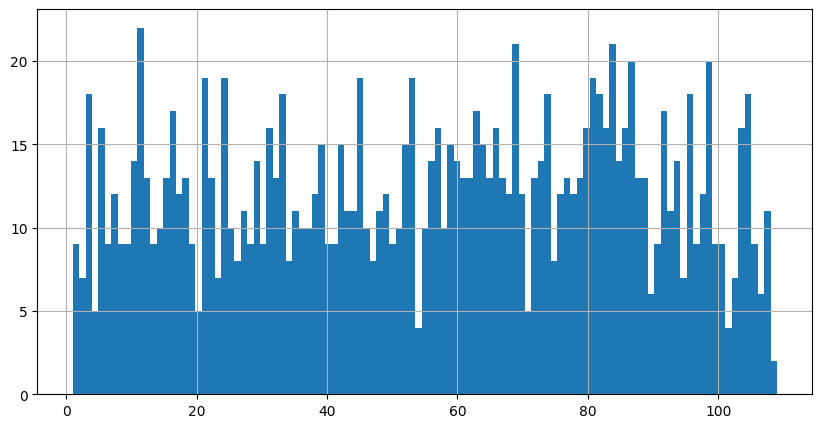

In [642]:
ratings["img"].hist(bins=max(ratings["img"]))

# Ratings Distribution

In [643]:
def analyse_columns(column, ratings):
    fig, axes = plt.subplots(1, 4)
    fig.suptitle(column, fontsize=16)
    ratings[column].hist(bins=max(ratings[column]), ax=axes[0])
    axes[0].set_title('all')
    ratings[ratings["type"] == "human"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]), ax=axes[1])
    axes[1].set_title('human')
    ratings[ratings["type"] == "semi-realistic"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                              ax=axes[2])
    axes[2].set_title('semi-realistic')
    ratings[ratings["type"] == "animated_grey"][column].hist(bins=1 + max(ratings[column]) - min(ratings[column]),
                                                             ax=axes[3])
    axes[3].set_title('animated_grey')
    plt.show()
    f, f_p = scipy.stats.f_oneway(ratings[ratings["type"] == "human"][column],
                                  ratings[ratings["type"] == "semi-realistic"][column],
                                  ratings[ratings["type"] == "animated_grey"][column])
    u, u_p = scipy.stats.mannwhitneyu(ratings[ratings["type"] == "semi-realistic"][column],
                                      ratings[ratings["type"] == "animated_grey"][
                                          column])

    print(
        "Human: {:.2f}, Semi Realistic: {:.2f}, Cartoon: {:.2f}, Anova p-value: {:.2f}, Mann–Whitney p-value: {:.2f} (semi vs cart)".format(
            ratings[ratings["type"] == "human"][column].mean(),
            ratings[ratings["type"] == "semi-realistic"][column].mean(),
            ratings[ratings["type"] == "animated_grey"][column].mean(), f_p, u_p))

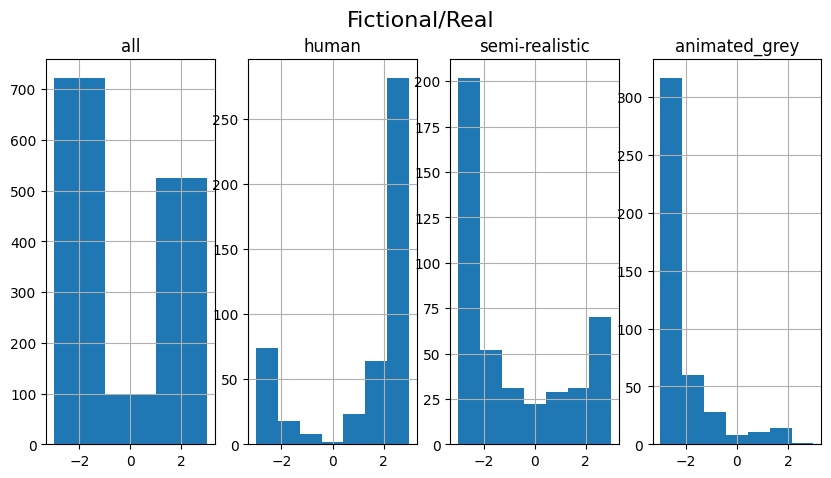

Human: 1.55, Semi Realistic: -1.01, Cartoon: -2.41, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


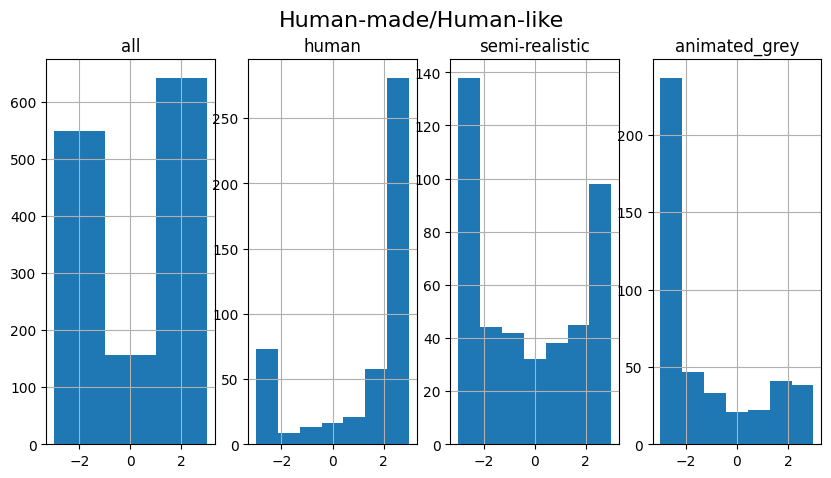

Human: 1.55, Semi Realistic: -0.28, Cartoon: -1.41, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


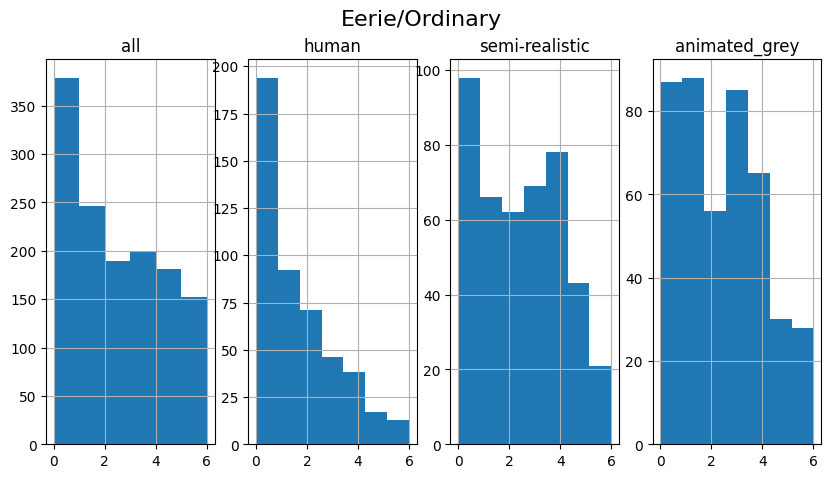

Human: 1.46, Semi Realistic: 2.40, Cartoon: 2.35, Anova p-value: 0.00, Mann–Whitney p-value: 0.67 (semi vs cart)


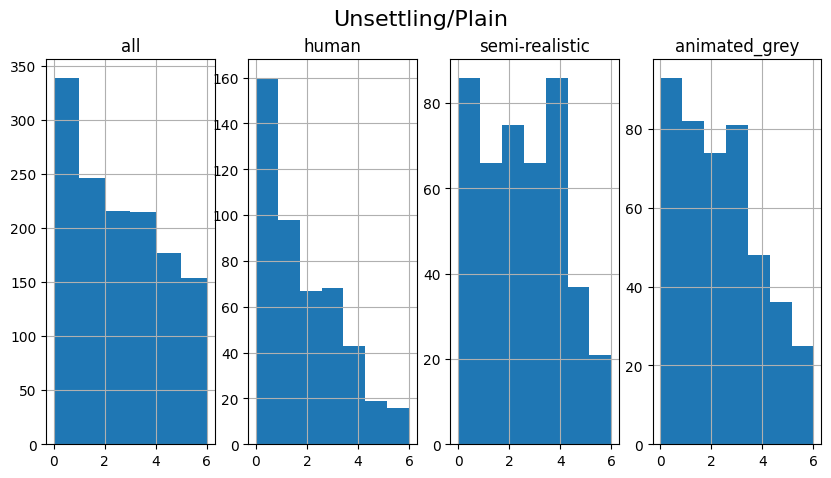

Human: 1.70, Semi Realistic: 2.45, Cartoon: 2.27, Anova p-value: 0.00, Mann–Whitney p-value: 0.11 (semi vs cart)


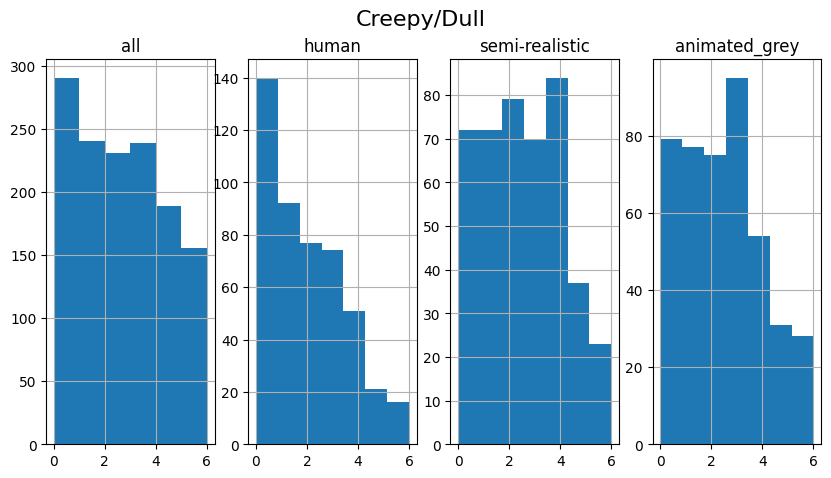

Human: 1.85, Semi Realistic: 2.51, Cartoon: 2.39, Anova p-value: 0.00, Mann–Whitney p-value: 0.25 (semi vs cart)


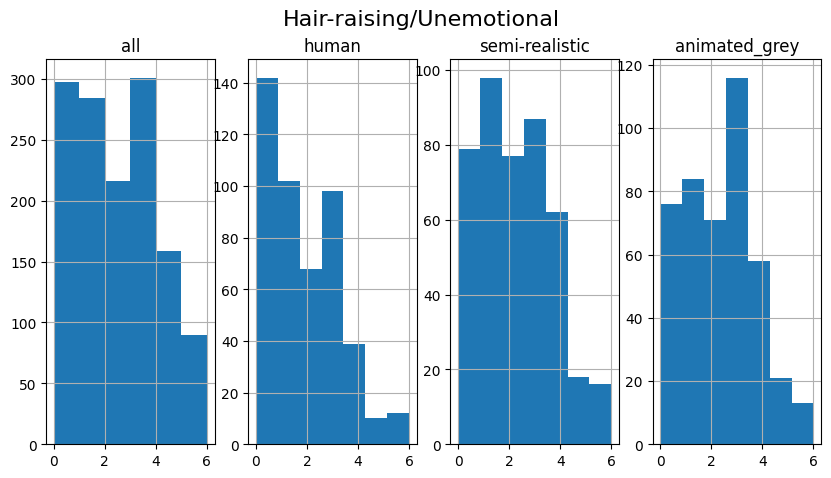

Human: 1.72, Semi Realistic: 2.17, Cartoon: 2.25, Anova p-value: 0.00, Mann–Whitney p-value: 0.35 (semi vs cart)


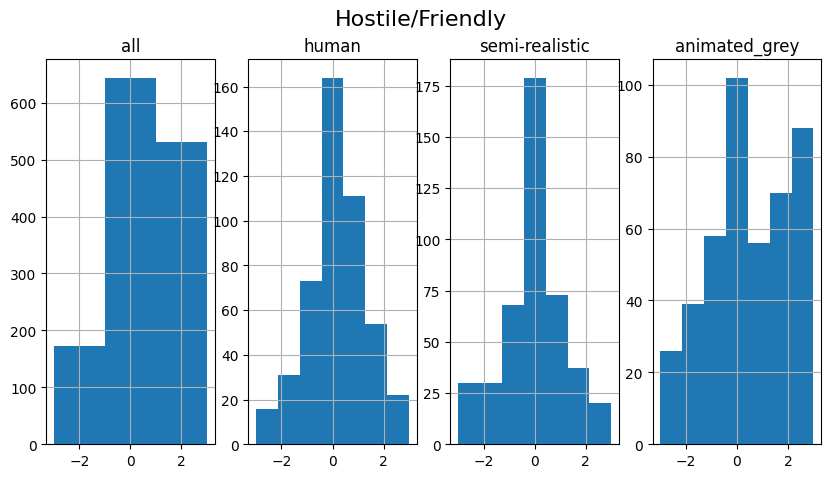

Human: 0.22, Semi Realistic: -0.03, Cartoon: 0.56, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


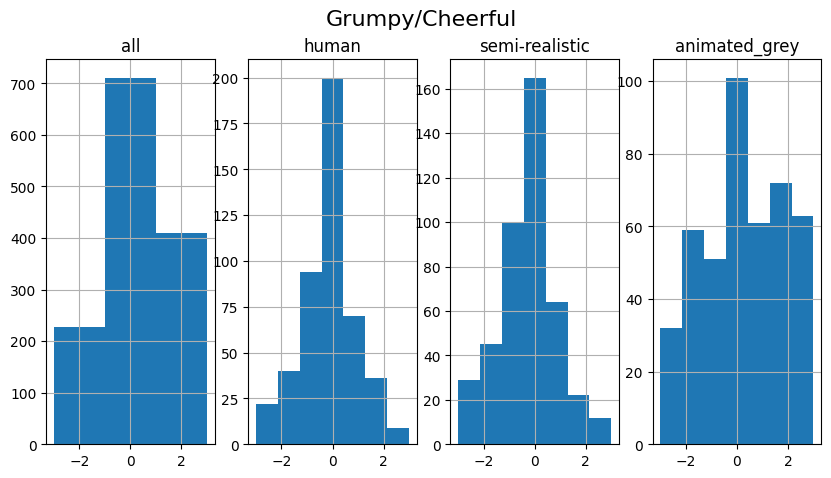

Human: -0.15, Semi Realistic: -0.30, Cartoon: 0.29, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


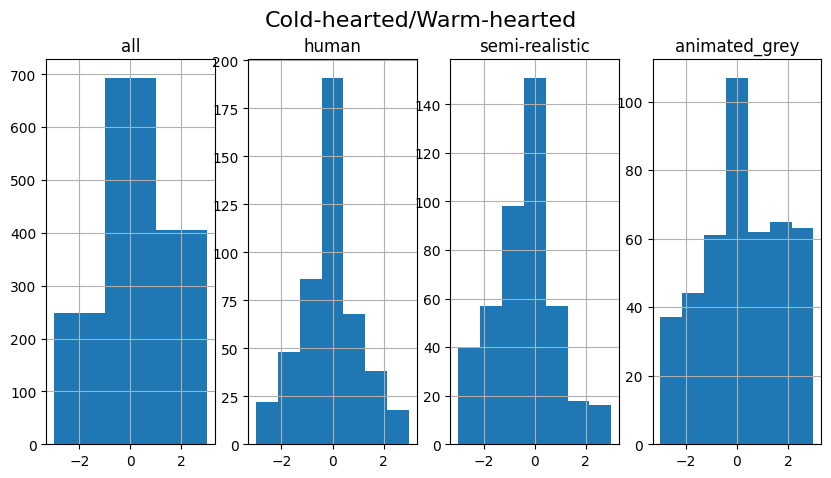

Human: -0.11, Semi Realistic: -0.44, Cartoon: 0.28, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


In [644]:
for column in questions:
    analyse_columns(column, ratings)

# Exploratory Factor Analysis

In [645]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

items = ratings[questions]
chi_square_value, p_value = calculate_bartlett_sphericity(items)
print("Bartlett ’s test:")
print(chi_square_value, p_value)
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(items)
print("KMO:")
print(kmo_model)
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(items)
print("Loadings:")
print(fa.loadings_)

Bartlett ’s test:
8733.738223971435 0.0
KMO:
0.8107612833219614
Loadings:
[[-0.18062264 -0.10321391  0.87314025]
 [-0.11305365 -0.04943921  0.84719433]
 [ 0.78949693 -0.19611327 -0.22638563]
 [ 0.87959082 -0.24810313 -0.10611805]
 [ 0.86165137 -0.27111017 -0.07346904]
 [ 0.71482305 -0.16316392 -0.0935771 ]
 [-0.32240481  0.85152461 -0.06099065]
 [-0.17225828  0.83996091 -0.07611403]
 [-0.2415809   0.85813928 -0.05126865]]


# Factors distributions

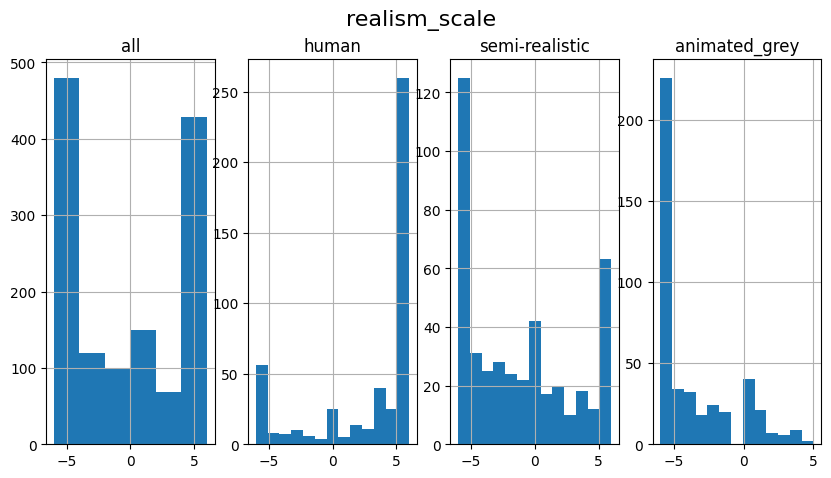

Human: 3.10, Semi Realistic: -1.29, Cartoon: -3.82, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


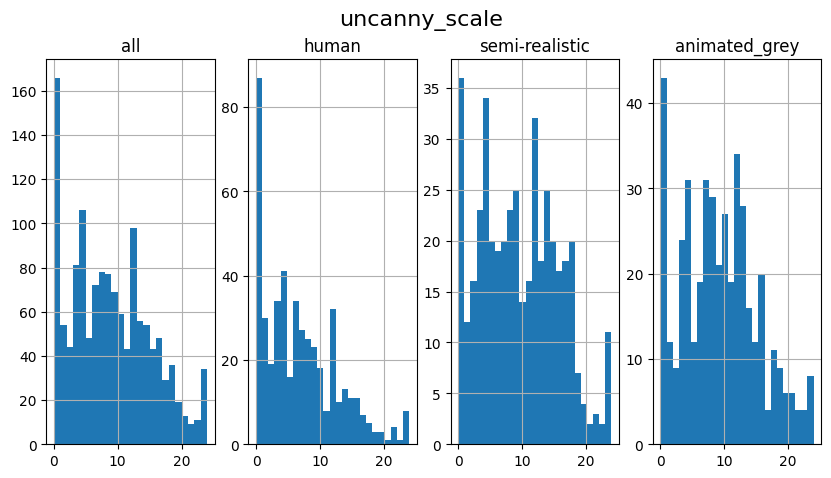

Human: 6.73, Semi Realistic: 9.53, Cartoon: 9.27, Anova p-value: 0.00, Mann–Whitney p-value: 0.49 (semi vs cart)


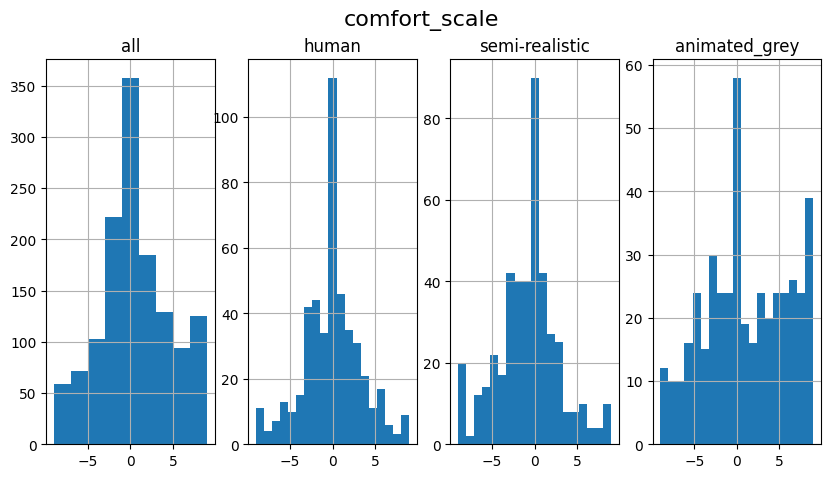

Human: -0.04, Semi Realistic: -0.77, Cartoon: 1.13, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


In [646]:
ratings["realism_scale"] = ratings["Fictional/Real"] + ratings["Human-made/Human-like"]
ratings["uncanny_scale"] = ratings["Eerie/Ordinary"] + ratings["Unsettling/Plain"] + ratings[
    "Creepy/Dull"] + ratings["Hair-raising/Unemotional"]
ratings["comfort_scale"] = ratings["Hostile/Friendly"] + ratings["Grumpy/Cheerful"] + ratings[
    "Cold-hearted/Warm-hearted"]

for column in ["realism_scale", "uncanny_scale", "comfort_scale"]:
    analyse_columns(column, ratings)

# Best 90 Images

In [655]:
cohort_size = 30
best_images = pd.concat([
ratings[ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size],
ratings[ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=False).reset_index()["img"][:cohort_size],
ratings[ratings["type"] == "animated_grey"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size]
    ]).to_list()
top_ratings = ratings[ratings["img"].isin(best_images)]

/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_72167/2231100747.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings[ratings["type"] == "human"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=True).reset_index()["img"][:cohort_size],
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_72167/2231100747.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings[ratings["type"] == "semi-realistic"].groupby("img").mean().sort_values(by="uncanny_scale", ascending=False).reset_index()["img"][:cohort_size],
/var/folders/t7/m4fy3kb90jb91658d6n8mc940000gn/T/ipykernel_72167

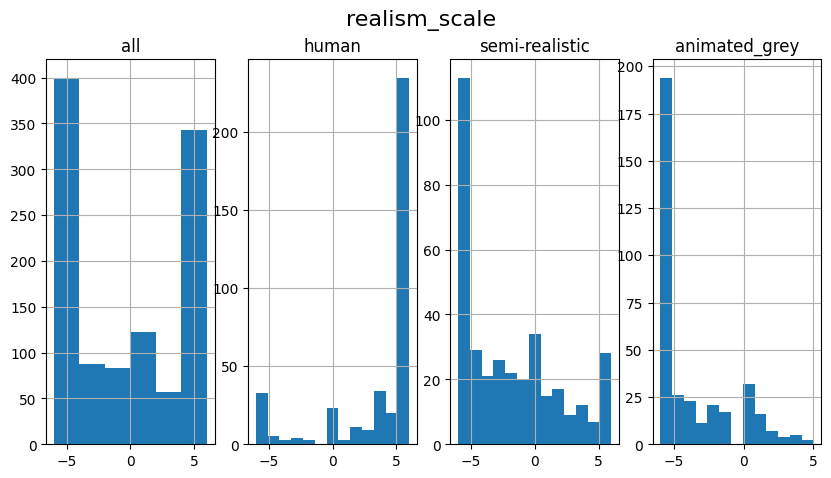

Human: 3.77, Semi Realistic: -2.05, Cartoon: -3.93, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


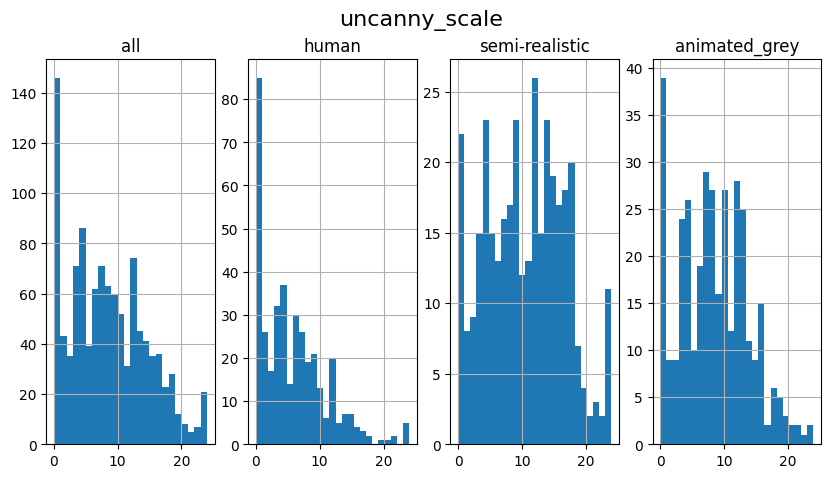

Human: 5.58, Semi Realistic: 10.53, Cartoon: 8.31, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


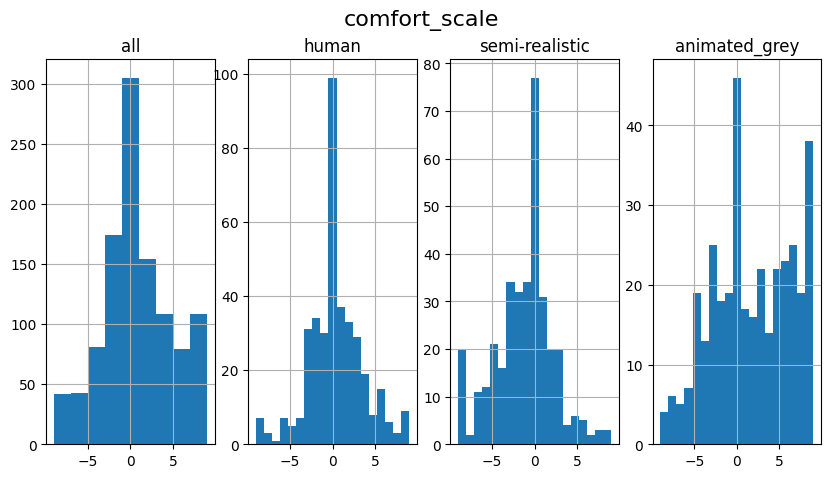

Human: 0.43, Semi Realistic: -1.25, Cartoon: 1.82, Anova p-value: 0.00, Mann–Whitney p-value: 0.00 (semi vs cart)


In [656]:
for column in ["realism_scale", "uncanny_scale", "comfort_scale"]:
    analyse_columns(column, top_ratings)